<a href="https://colab.research.google.com/github/4232177191/project1/blob/main/deiabet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimal number of clusters: 3
Results for Percentage: 0.11
    Actual Target  Predicted Target (Overall)  \
0           160.0                        81.8   
1           253.0                       120.2   
2           151.0                       175.8   
3           124.0                       190.0   
4            89.0                       101.2   
5           263.0                       184.6   
6           242.0                       238.8   
7           107.0                       104.0   
8           270.0                       267.4   
9           161.0                       156.4   
10          332.0                       223.2   
11          265.0                       213.4   
12          252.0                       138.6   
13          220.0                       173.2   
14          164.0                       133.6   
15           57.0                        88.6   
16           80.0                       115.4   
17          155.0                       219.8   
18        

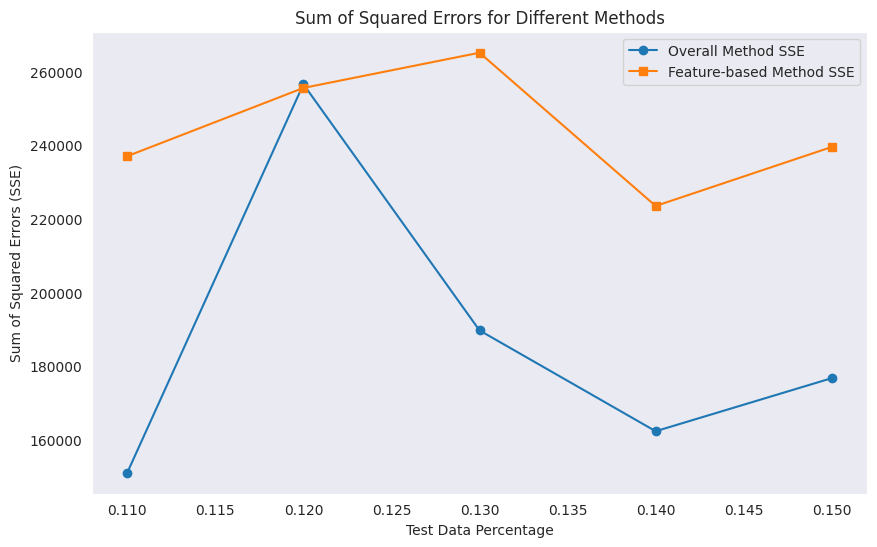

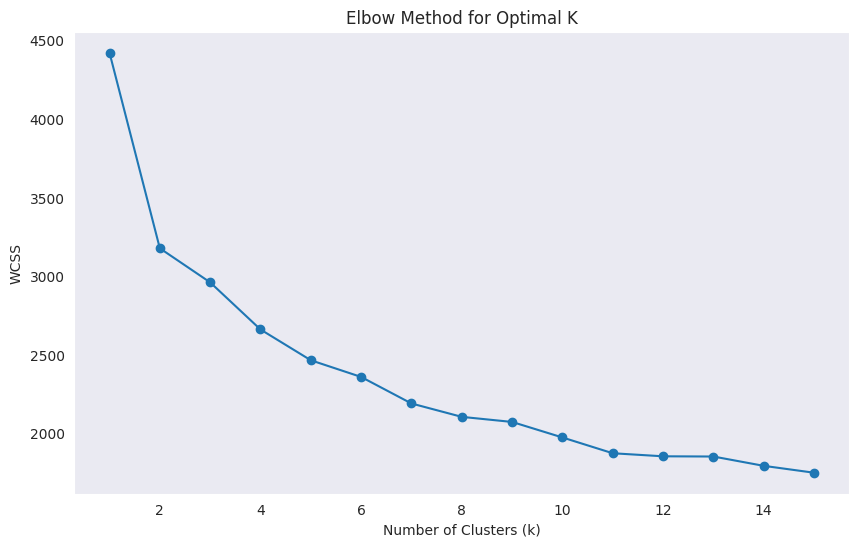

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from seaborn import set_style

set_style('darkgrid')

# بارگذاری دیتا ست دیابت
diabet = load_diabetes()
data = pd.DataFrame(diabet.data, columns=diabet.feature_names)
data["target"] = diabet.target

# پیش‌پردازش داده‌ها (استانداردسازی)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:, :-1])  # تمامی ستون‌ها به جز ستون نتیجه

# استفاده از K-Means برای تعیین تعداد کلاستر
wcss = []
max_k = 15

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

diff = np.diff(wcss)
diff2 = np.diff(diff)
optimal_k = np.argmin(diff2) + 2
print(f"Optimal number of clusters: {optimal_k}")

# اجرای K-Means با تعداد کلاسترهای بهینه
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(data_scaled)
data['Cluster'] = kmeans.labels_

# محاسبه میانگین هدف برای هر کلاستر
cluster_means = data.groupby('Cluster')['target'].mean().reset_index()
cluster_means.rename(columns={'target': 'Cluster_Mean_Target'}, inplace=True)

# ایجاد مجموعه تست
percentages = np.arange(0.11, 0.16, 0.01)
sse_overall = []
sse_feature_based = []

for p in percentages:
    test_size = int(len(data) * p)
    test_data = data.sample(n=test_size)
    train_data = data.drop(test_data.index)

    if len(train_data) < 1:
        print("No data available for training.")
        continue

    # KNN کلی (نامشخص)
    knn_overall = KNeighborsRegressor(n_neighbors=min(5, len(train_data)//2))  # تعداد همسایه‌ها
    knn_overall.fit(data_scaled[train_data.index], train_data['target'])
    overall_predictions = knn_overall.predict(scaler.transform(test_data.iloc[:, :-2]))

    # KNN ویژگی‌محور (نامشخص)
    feature_based_predictions = []  # لیست پیش‌بینی‌های ویژگی‌محور
    for i in range(data.shape[1] - 2):  # به جز ستون‌های target و Cluster
        X_train_feature = train_data.iloc[:, [i]].values
        X_test_feature = test_data.iloc[:, [i]].values

        knn_feature = KNeighborsRegressor(n_neighbors=min(5, len(train_data)//2))
        knn_feature.fit(X_train_feature, train_data['target'])
        feature_predictions = knn_feature.predict(X_test_feature)
        feature_based_predictions.append(feature_predictions)

    # میانگین پیش‌بینی‌های ویژگی‌محور
    feature_based_predictions = np.mean(feature_based_predictions, axis=0)

    # محاسبه مجموع مربعات اختلاف برای هر روش
    overall_difference = overall_predictions - test_data['target'].values
    feature_based_difference = feature_based_predictions - test_data['target'].values

    # محاسبه SSE برای هر روش
    sse_overall.append(np.sum(overall_difference ** 2))
    sse_feature_based.append(np.sum(feature_based_difference ** 2))

    # اختصاص میانگین هدف کلاستر به پیش‌بینی‌های نهایی
    test_data = test_data.merge(cluster_means, on='Cluster', how='left')
    cluster_target_predictions = test_data['Cluster_Mean_Target'].values

    # نمایش اختلافات و نتایج پیش‌بینی
    result_df = pd.DataFrame({
        "Actual Target": test_data['target'].values,
        "Predicted Target (Overall)": overall_predictions,
        "Predicted Target (Feature-based)": feature_based_predictions,
        "Predicted Target (Cluster Mean)": cluster_target_predictions,
        "Difference (Overall)": overall_difference,
        "Difference (Feature-based)": feature_based_difference,
        "Difference (Cluster Mean)": cluster_target_predictions - test_data['target'].values
    })

    print(f"Results for Percentage: {p:.2f}")
    print(result_df[['Actual Target', 'Predicted Target (Overall)', 'Predicted Target (Feature-based)',
                     'Predicted Target (Cluster Mean)', 'Difference (Overall)',
                     'Difference (Feature-based)', 'Difference (Cluster Mean)']])
    print("\n")

# رسم نمودار مجموع مربعات اختلاف
plt.figure(figsize=(10, 6))
plt.plot(percentages, sse_overall, marker='o', label='Overall Method SSE')
plt.plot(percentages, sse_feature_based, marker='s', label='Feature-based Method SSE')
plt.title('Sum of Squared Errors for Different Methods')
plt.xlabel('Test Data Percentage')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.legend()
plt.grid()
plt.show()

# رسم نمودار البو
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid()
plt.show()